In [64]:
from bioservices.kegg import KEGG
import pandas as pd
import os
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import re
from openpyxl import load_workbook

In [74]:
#Sets the path
path = 'C:/Users/Alyssa/OneDriveWash UResearch2022 SpringRNA seqYarlipExpression_2Transcriptome Analysis'
os.chdir(path)

k = KEGG()
k.organism = 'ath'

DEG_data_dvsa = pd.ExcelFile('C:/Users/Alyssa/Documents/RNA seq/dvsa_DEG.xlsx').parse('dvsa_DEG')
DEG_data_dvsb = pd.ExcelFile('C:/Users/Alyssa/Documents/RNA seq/dvsb_DEG.xlsx').parse('dvsb_DEG')
DEG_data_bvsa = pd.ExcelFile('C:/Users/Alyssa/Documents/RNA seq/bvsa_DEG.xlsx').parse('bvsa_DEG')
DEG_data_dvsa.index=DEG_data_dvsa['gene_id']
DEG_data_dvsb.index=DEG_data_dvsb['gene_id']
DEG_data_bvsa.index=DEG_data_bvsa['gene_id']
#DEG_data_dvsa

DEG_data = pd.DataFrame(dtype=float)
DEG_data = pd.DataFrame(index=DEG_data_dvsa['gene_id'].values)
DEG_data['geneID'] = DEG_data_dvsa['gene_id'].values
DEG_data['dvsa'] = DEG_data_dvsa['log2foldchange'].values
DEG_data['dvsa_pval'] = DEG_data_dvsa['padjust'].values


for g in DEG_data.index:
    gene = g
    #print(gene)
    for g2 in DEG_data_dvsb['gene_id']:
       # print(g2)
        if g2 == g:
            location = g2
            #print(location)
            DEG_data.loc[g,'dvsb'] = DEG_data_dvsb.loc[g,'log2foldchange']
            DEG_data.loc[g,'dvsb_pval'] = DEG_data_dvsb.loc[g,'padjust']
            
for g in DEG_data.index:
    gene = g
    #print(gene)
    for g2 in DEG_data_bvsa['gene_id']:
       # print(g2)
        if g2 == g:
            location = g2
            #print(location)
            DEG_data.loc[g,'bvsa'] = DEG_data_bvsa.loc[g,'log2foldchange']
            DEG_data.loc[g,'bvsa_pval'] = DEG_data_bvsa.loc[g,'padjust']
            
DEG_data['description']=DEG_data_dvsa['gene_descrip'].values
            
DEG_data

,geneID,dvsa,dvsa_pval,dvsb,dvsb_pval,bvsa,bvsa_pval,description
AT1G13650,AT1G13650,-3.243279,4.312614e-50,-3.435204,8.268529e-176,0.188997,5.110371e-01,At1g13650
AT1G76520,AT1G76520,2.895107,6.354082e-44,0.886593,3.481857e-13,2.015931,2.511249e-17,Protein PIN-LIKES 3
ATCG00790,ATCG00790,3.120476,1.944929e-43,-0.964006,1.613185e-02,4.089556,1.119202e-79,"50S ribosomal protein L16, chloroplastic"
AT1G56660,AT1G56660,3.726250,6.798822e-37,0.288105,5.317160e-02,3.442123,1.968799e-31,F25P12.91 protein
AT5G18600,AT5G18600,-5.297230,6.195149e-36,-1.353912,3.149906e-01,-4.160240,1.004051e-37,Monothiol glutaredoxin-S2
...,...,...,...,...,...,...,...,...
AT3G44110,AT3G44110,-0.000073,9.998614e-01,-0.425192,5.176917e-04,0.432759,5.920991e-02,DnaJ protein homolog atj3
AT4G15130,AT4G15130,-0.000142,9.998614e-01,-0.567939,2.418024e-01,0.581986,2.357227e-01,phosphorylcholine cytidylyltransferase2
AT3G47180,AT3G47180,-0.000902,9.998614e-01,3.655540,1.000000e+00,-3.574241,1.000000e+00,At3g47180
AT4G18422,AT4G18422,0.000230,9.999377e-01,1.204024,8.670035e-01,-1.247481,7.317166e-01,unknown protein; FUNCTIONS IN: molecular_funct...


In [33]:
DEG_data.drop(['AT5G45040'], inplace = True )

In [42]:
def parseKeggBiochemPathways(pathways,pathway_dict,DEG_dataCopy,resetKeggCode=True):
      
    if resetKeggCode==True:
        DEG_data['KEGG_pathway'] = '0'
        
    #biochem is the biochemical pathway (i.e., glycolysis)
    
    for biochem in pathways:
        data = k.get(biochem)
        dict_data = k.parse(data)

        for gene in dict_data['GENE']:

            if (gene in DEG_dataCopy.index):
                DEG_dataCopy.loc[gene,'KEGG_geneAbbreviation'] = dict_data['GENE'][gene].split('; ')[0]

                if (DEG_dataCopy.loc[gene,'KEGG_pathway'] =='0'):
                    DEG_dataCopy.loc[gene,'KEGG_pathway'] = pathway_dict[biochem]
                else:
                    DEG_dataCopy.loc[gene,'KEGG_pathway'] = DEG_dataCopy.loc[gene,'KEGG_pathway']+';'+pathway_dict[biochem]
            else:
                print('Kegg gene {} not found in RNA Seq data'.format(gene))
    return(DEG_dataCopy)

def colorPlotting(df,xTICKS,transpose=False):
    xTICKtemp = []
    for item in xTICKS:
        try:
            xTICKtemp.append(item.split('[')[0])
        except Exception as e:
            xTICKtemp.append(item)
    fig, ax = plt.subplots()
    if transpose==False:        
        plt.imshow(df.T, cmap = 'bwr') 
        plt.clim(-4,4)
        # # Displaying a color bar to understand 
        # # which color represents which range of data 
        plt.colorbar(orientation="horizontal") 
        # # Assigning labels of x-axis  
        # # according to dataframe 
        plt.yticks(range(len(df.columns)), df.columns) 
        # # Assigning labels of y-axis  
        # # according to dataframe 
        plt.xticks(range(len(df)), xTICKtemp) 
        fig = plt.gcf()
        fig.set_size_inches(17,3) 
        ax.xaxis.tick_top()
        plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees
        plt.show() 
    else:
        plt.imshow(df, cmap = 'bwr') 
        plt.clim(-4,4)
        # # Displaying a color bar to understand 
        # # which color represents which range of data 
        plt.colorbar() 
        # # Assigning labels of x-axis  
        # # according to dataframe 
        plt.xticks(range(len(df.columns)), df.columns) 
        # # Assigning labels of y-axis  
        # # according to dataframe 
        plt.yticks(range(len(df)), xTICKtemp) 
        fig = plt.gcf()
        fig.set_size_inches(3,17) 
        ax.xaxis.tick_top()
        plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees
        plt.show() 
        
DEG_data['KEGG_geneAbbreviation'] = '0'
DEG_data['KEGG_pathway'] = '0'

def df_sorter(df,dropOption=0):
    
    df = df[df.KEGG_pathway!='0'].copy()

    df.sort_values(by=['KEGG_pathway'],inplace=True)
  #  df.rename(columns={'DEG Log2 Ratio (0h;327vs219)':'327vs219(0h)','DEG Log2 Ratio (12h;327vs219)':'327vs219(12h)','DEG Log2 Ratio (327;12hvs0h)': '327(12vs0h)',
            #       'DEG Log2 Ratio (327;24hvs0h)':'327(24vs0h)'},inplace=True)
    df2 = df.copy()
    df3 = df.copy()

    if dropOption==0:
        df2.drop(columns = ['bvsa_pval','dvsb_pval', 'dvsa_pval', 'description'
                   ,'geneID','KEGG_geneAbbreviation','KEGG_pathway'],inplace=True)
        df3.drop(columns = ['geneID','KEGG_geneAbbreviation'],inplace=True)
    elif dropOption==1:
        df2.drop(columns = ['bvsa_pval','dvsb_pval', 'dvsa_pval', 'description'
                   ,'geneID','KEGG_geneAbbreviation','KEGG_pathway','bvsa','dvsb'],inplace=True)
    else:
        df2.drop(columns = ['bvsa_pval','dvsb_pval', 'dvsa_pval' , 'description'
                   ,'geneID','KEGG_geneAbbreviation','KEGG_pathway','dvsb','dvsa'],inplace=True)
    return df2,df3,df['description']

    

In [61]:
writer = pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')

Kegg gene AT4G39650 not found in RNA Seq data
Kegg gene AT1G69820 not found in RNA Seq data
Kegg gene AT3G03190 not found in RNA Seq data
Kegg gene AT2G29480 not found in RNA Seq data
Kegg gene AT2G02930 not found in RNA Seq data
Kegg gene AT3G62760 not found in RNA Seq data
Kegg gene AT1G49860 not found in RNA Seq data
Kegg gene AT1G59670 not found in RNA Seq data
Kegg gene AT2G29470 not found in RNA Seq data
Kegg gene AT5G02780 not found in RNA Seq data
Kegg gene AT1G17180 not found in RNA Seq data
Kegg gene AT1G27140 not found in RNA Seq data
Kegg gene AT1G69920 not found in RNA Seq data
Kegg gene AT1G69930 not found in RNA Seq data
Kegg gene AT1G78360 not found in RNA Seq data
Kegg gene AT5G62480 not found in RNA Seq data
Kegg gene AT1G19550 not found in RNA Seq data
Kegg gene AT1G48130 not found in RNA Seq data
Kegg gene AT3G09640 not found in RNA Seq data


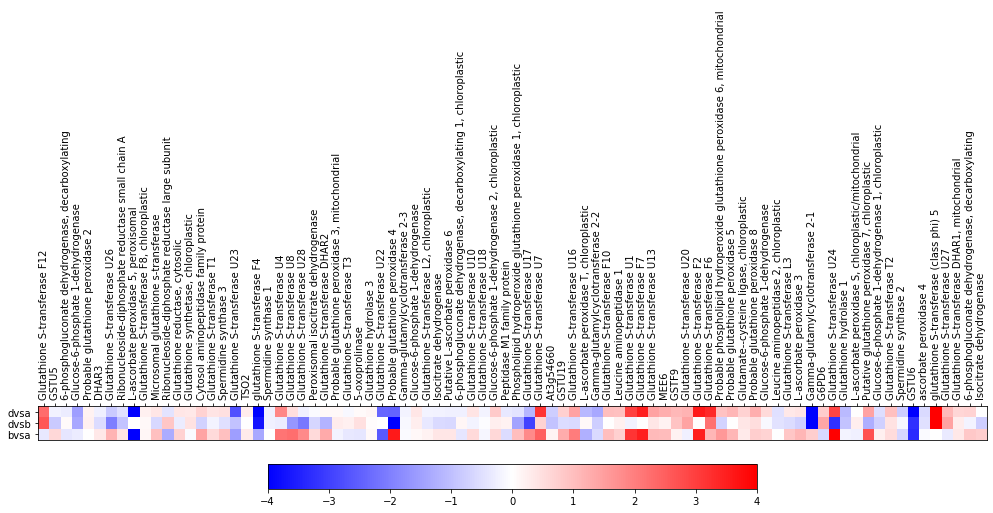

In [65]:
#pathways to initially parse
pathwaysToExplore = ['ath00480']
annotation = ['glutathione']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description

Kegg gene ArthCp002 not found in RNA Seq data
Kegg gene ArthCp049 not found in RNA Seq data
Kegg gene ArthCp018 not found in RNA Seq data
Kegg gene ArthCp017 not found in RNA Seq data
Kegg gene ArthCp039 not found in RNA Seq data
Kegg gene ArthCp038 not found in RNA Seq data
Kegg gene ArthCp052 not found in RNA Seq data
Kegg gene ArthCp006 not found in RNA Seq data
Kegg gene ArthCp036 not found in RNA Seq data
Kegg gene ArthCp005 not found in RNA Seq data
Kegg gene ArthCp037 not found in RNA Seq data
Kegg gene ArthCp016 not found in RNA Seq data
Kegg gene ArthCp050 not found in RNA Seq data
Kegg gene ArthCp019 not found in RNA Seq data
Kegg gene ArthCp022 not found in RNA Seq data
Kegg gene ArthCp021 not found in RNA Seq data
Kegg gene ArthCp075 not found in RNA Seq data
Kegg gene ArthCp032 not found in RNA Seq data
Kegg gene ArthCp042 not found in RNA Seq data
Kegg gene ArthCp035 not found in RNA Seq data
Kegg gene ArthCp053 not found in RNA Seq data
Kegg gene ArthCp054 not found in R

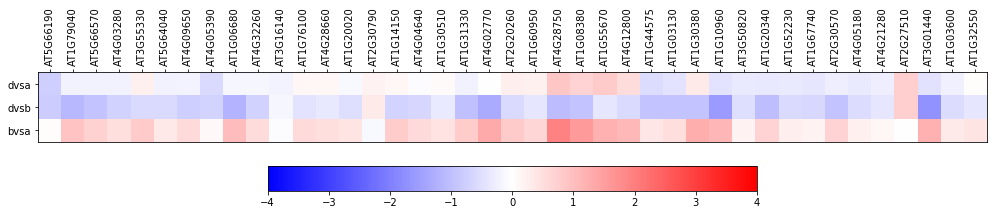

In [66]:
#photosynthesis
pathwaysToExplore = ['ath00195']
annotation = ['photosynthesis']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
colorPlotting(df2,df2.index) #plots with gene name
#colorPlotting(df2,df) #plots with gene description

Kegg gene ArthCp002 not found in RNA Seq data
Kegg gene ArthCp049 not found in RNA Seq data
Kegg gene ArthCp018 not found in RNA Seq data
Kegg gene ArthCp017 not found in RNA Seq data
Kegg gene ArthCp039 not found in RNA Seq data
Kegg gene ArthCp038 not found in RNA Seq data
Kegg gene ArthCp052 not found in RNA Seq data
Kegg gene ArthCp006 not found in RNA Seq data
Kegg gene ArthCp036 not found in RNA Seq data
Kegg gene ArthCp005 not found in RNA Seq data
Kegg gene ArthCp037 not found in RNA Seq data
Kegg gene ArthCp016 not found in RNA Seq data
Kegg gene ArthCp050 not found in RNA Seq data
Kegg gene ArthCp019 not found in RNA Seq data
Kegg gene ArthCp022 not found in RNA Seq data
Kegg gene ArthCp021 not found in RNA Seq data
Kegg gene ArthCp075 not found in RNA Seq data
Kegg gene ArthCp032 not found in RNA Seq data
Kegg gene ArthCp042 not found in RNA Seq data
Kegg gene ArthCp035 not found in RNA Seq data
Kegg gene ArthCp053 not found in RNA Seq data
Kegg gene ArthCp054 not found in R

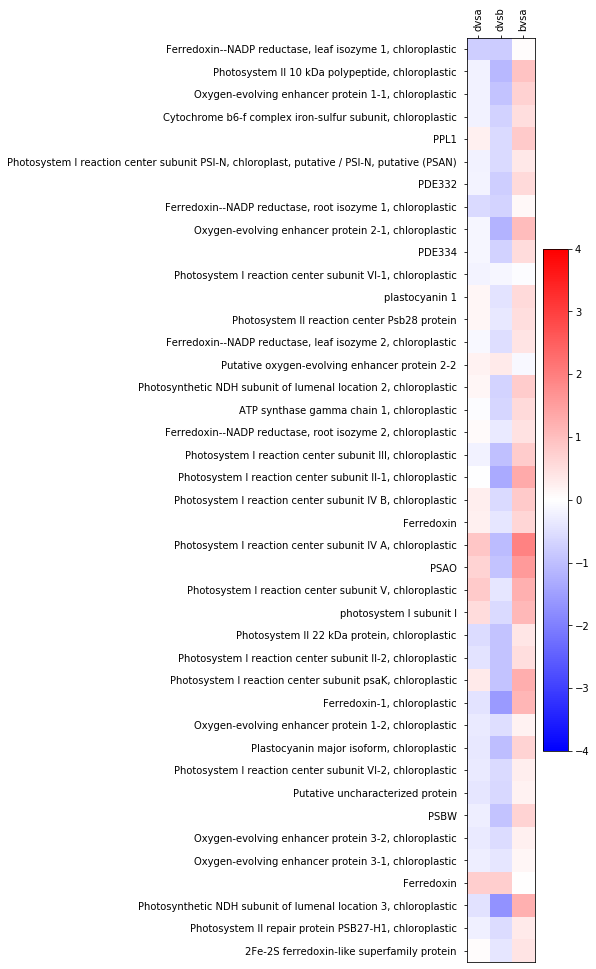

In [39]:
#photosynthesis
pathwaysToExplore = ['ath00195']
annotation = ['photosynthesis']
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df = df_sorter(dfx)
#colorPlotting(df2,df2.index) #plots with gene name
df2_show = df2
colorPlotting(df2,df,transpose=True) #plots with gene description

In [40]:
df2

,dvsa,dvsb,bvsa
AT5G66190,-0.757999,-0.805825,0.050198
AT1G79040,-0.206373,-1.118110,0.916851
AT5G66570,-0.216150,-0.912986,0.702375
AT4G03280,-0.207827,-0.717815,0.517029
AT3G55330,0.248617,-0.579466,0.824325
AT5G64040,-0.211745,-0.566264,0.359355
AT4G09650,-0.177521,-0.756663,0.584666
AT4G05390,-0.567930,-0.675727,0.100402
AT1G06680,-0.146487,-1.175620,1.034001
AT4G32260,-0.138609,-0.690054,0.558644


Kegg gene AT5G64000 not found in RNA Seq data
Kegg gene AT1G33320 not found in RNA Seq data
Kegg gene AT3G23800 not found in RNA Seq data


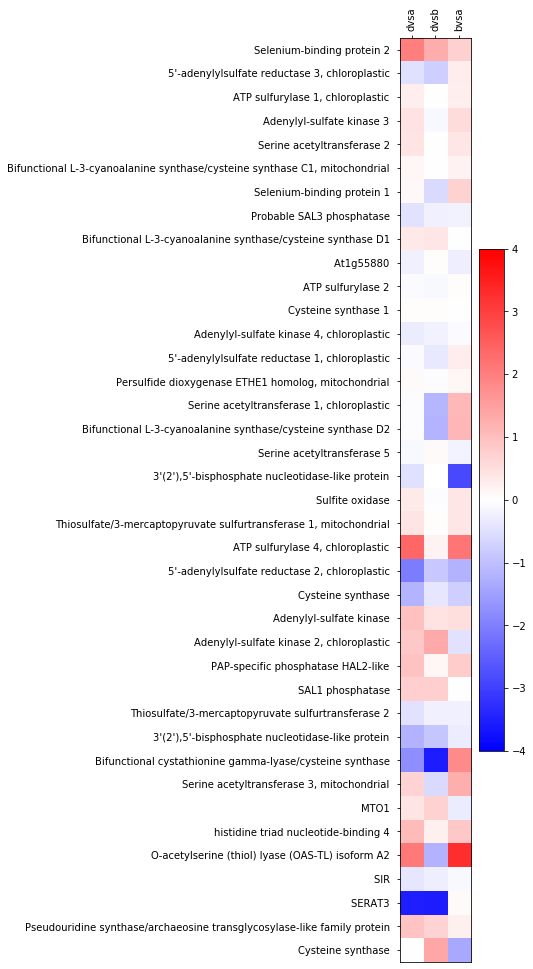

In [62]:
#sulfur metabolism
pathwaysToExplore = ['ath00920']
annotation = ['sulfur metabolism']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description

Kegg gene AT4G37840 not found in RNA Seq data
Kegg gene AT3G25960 not found in RNA Seq data
Kegg gene AT3G55810 not found in RNA Seq data
Kegg gene AT4G26390 not found in RNA Seq data
Kegg gene AT1G22440 not found in RNA Seq data
Kegg gene AT4G22110 not found in RNA Seq data
Kegg gene AT5G15140 not found in RNA Seq data
Kegg gene AT3G01260 not found in RNA Seq data


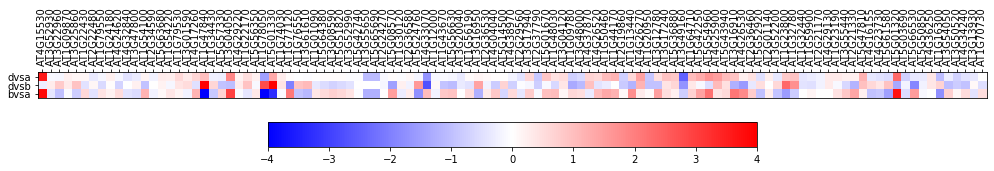

In [67]:
#carbon metabolism
pathwaysToExplore = ['ath00010']
annotation = ['glycolysis']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
colorPlotting(df2,df2.index) #plots with gene name
#colorPlotting(df2,df) #plots with gene description

Kegg gene AT5G23020 not found in RNA Seq data
Kegg gene AT1G50090 not found in RNA Seq data
Kegg gene AT5G05260 not found in RNA Seq data
Kegg gene AT5G35917 not found in RNA Seq data


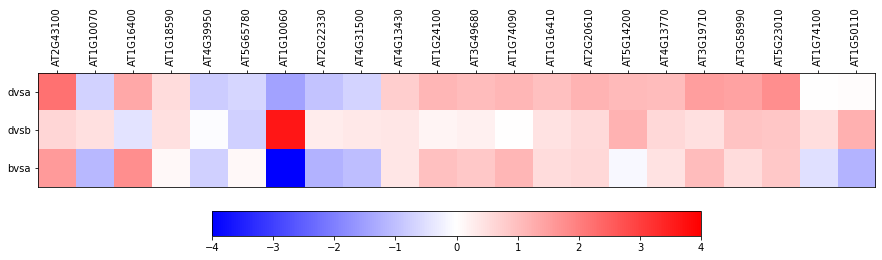

In [68]:
#carbon metabolism
pathwaysToExplore = ['ath00966']
annotation = ['glucosinolate']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
colorPlotting(df2,df2.index) #plots with gene name
#colorPlotting(df2,df) #plots with gene description

Kegg gene ArthCp079 not found in RNA Seq data
Kegg gene ArthCp068 not found in RNA Seq data
Kegg gene ArthCp086 not found in RNA Seq data
Kegg gene ArthCp027 not found in RNA Seq data
Kegg gene ArthCp074 not found in RNA Seq data
Kegg gene ArthCp076 not found in RNA Seq data
Kegg gene ArthCp071 not found in RNA Seq data
Kegg gene ArthCp077 not found in RNA Seq data
Kegg gene ArthCp080 not found in RNA Seq data
Kegg gene ArthCp078 not found in RNA Seq data
Kegg gene ArthCp025 not found in RNA Seq data
Kegg gene ArthCp026 not found in RNA Seq data
Kegg gene AT2G07785 not found in RNA Seq data
Kegg gene DA397_mgp34 not found in RNA Seq data
Kegg gene DA397_mgp31 not found in RNA Seq data
Kegg gene DA397_mgp14 not found in RNA Seq data
Kegg gene DA397_mgp23 not found in RNA Seq data
Kegg gene DA397_mgp04 not found in RNA Seq data
Kegg gene DA397_mgp37 not found in RNA Seq data
Kegg gene DA397_mgp28 not found in RNA Seq data
Kegg gene DA397_mgp19 not found in RNA Seq data
Kegg gene DA397_mg

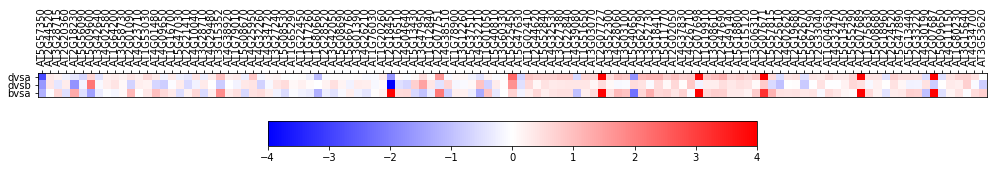

In [69]:
#
pathwaysToExplore = ['ath00190']
annotation = ['Oxidative phosphorylation']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
colorPlotting(df2,df2.index) #plots with gene name
#colorPlotting(df2,df) #plots with gene description

Kegg gene AT2G16570 not found in RNA Seq data
Kegg gene AT4G38880 not found in RNA Seq data
Kegg gene AT4G23900 not found in RNA Seq data
Kegg gene AT1G14240 not found in RNA Seq data


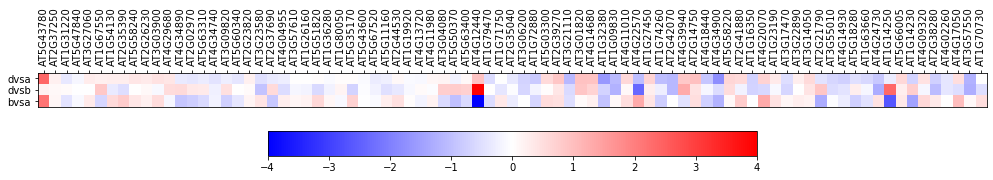

In [71]:
#
pathwaysToExplore = ['ath00230']
annotation = ['nucleotide metabolism']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
colorPlotting(df2,df2.index) #plots with gene name
#colorPlotting(df2,df) #plots with gene description

Kegg gene AT4G23900 not found in RNA Seq data
Kegg gene AT1G14240 not found in RNA Seq data
Kegg gene AT2G34890 not found in RNA Seq data
Kegg gene AT3G27440 not found in RNA Seq data
Kegg gene AT2G19570 not found in RNA Seq data
Kegg gene AT4G29570 not found in RNA Seq data
Kegg gene AT4G29640 not found in RNA Seq data
Kegg gene AT4G29620 not found in RNA Seq data
Kegg gene AT4G29630 not found in RNA Seq data


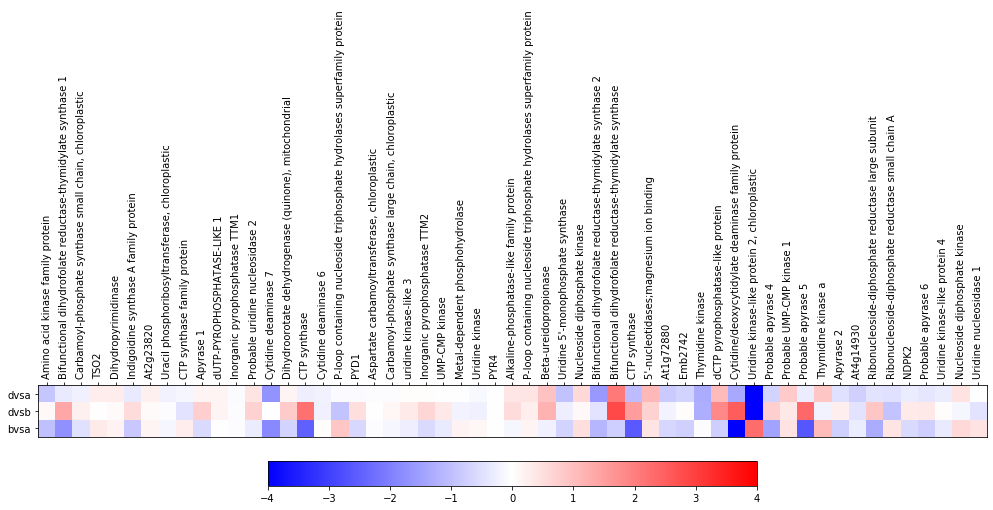

In [73]:
#
pathwaysToExplore = ['ath00240']
annotation = ['nucleotide metabolism']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
#book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
#with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
#    writer.book = book
#    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
#    df3.to_excel(writer, name)  

#    writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description

Kegg gene AT3G58740 not found in RNA Seq data
Kegg gene AT3G60100 not found in RNA Seq data
Kegg gene AT4G35650 not found in RNA Seq data
Kegg gene AT1G32480 not found in RNA Seq data
Kegg gene AT5G65165 not found in RNA Seq data


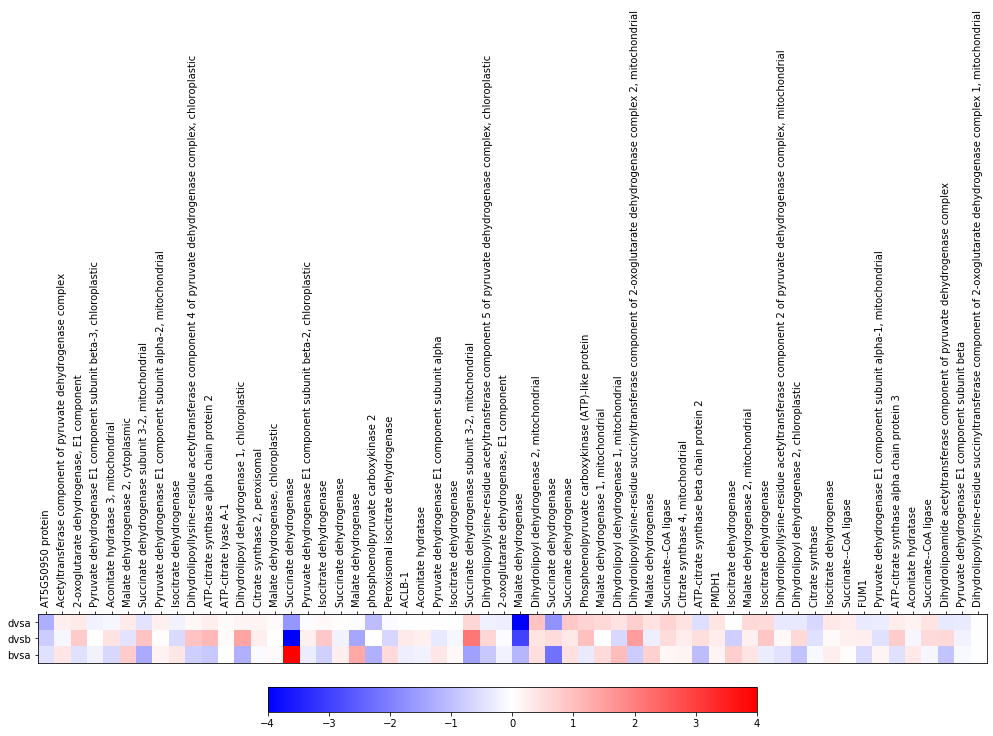

In [75]:
#
pathwaysToExplore = ['ath00020']
annotation = ['TCA cycle']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
colorPlotting(df2,df2.index) #plots with gene name
#colorPlotting(df2,df) #plots with gene description

Kegg gene AT5G24410 not found in RNA Seq data


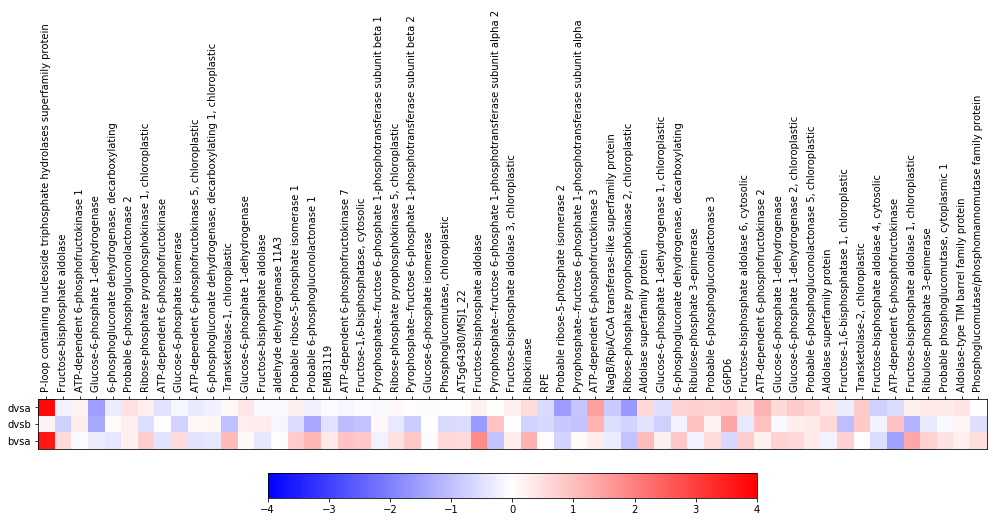

In [76]:
pathwaysToExplore = ['ath00030']
annotation = ['pentose phosphate']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description

Kegg gene AT1G08100 not found in RNA Seq data
Kegg gene AT1G08090 not found in RNA Seq data
Kegg gene AT5G60770 not found in RNA Seq data
Kegg gene AT5G60780 not found in RNA Seq data
Kegg gene AT1G12940 not found in RNA Seq data
Kegg gene AT4G21000 not found in RNA Seq data
Kegg gene AT1G08080 not found in RNA Seq data
Kegg gene AT1G08065 not found in RNA Seq data
Kegg gene AT5G56330 not found in RNA Seq data


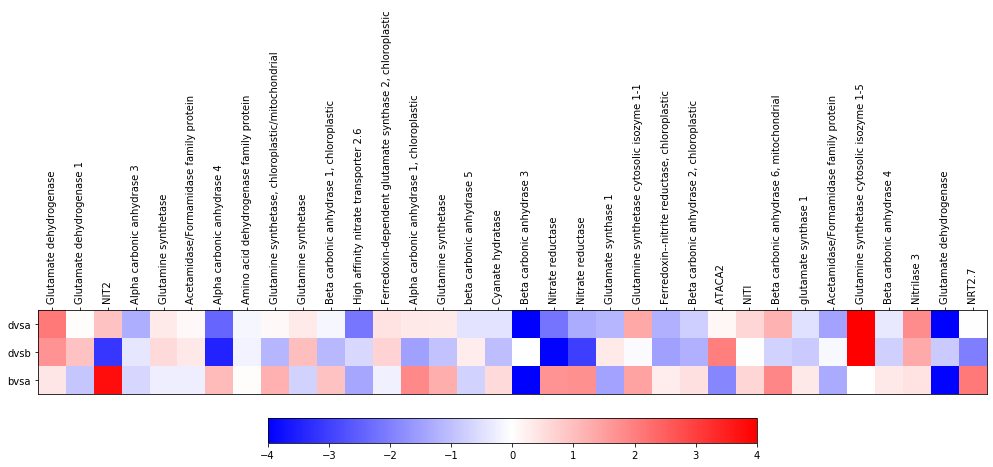

In [77]:
pathwaysToExplore = ['ath00910']
annotation = ['nitrogen metabolism']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description

Kegg gene AT1G03810 not found in RNA Seq data
Kegg gene AT1G49250 not found in RNA Seq data
Kegg gene AT2G27120 not found in RNA Seq data


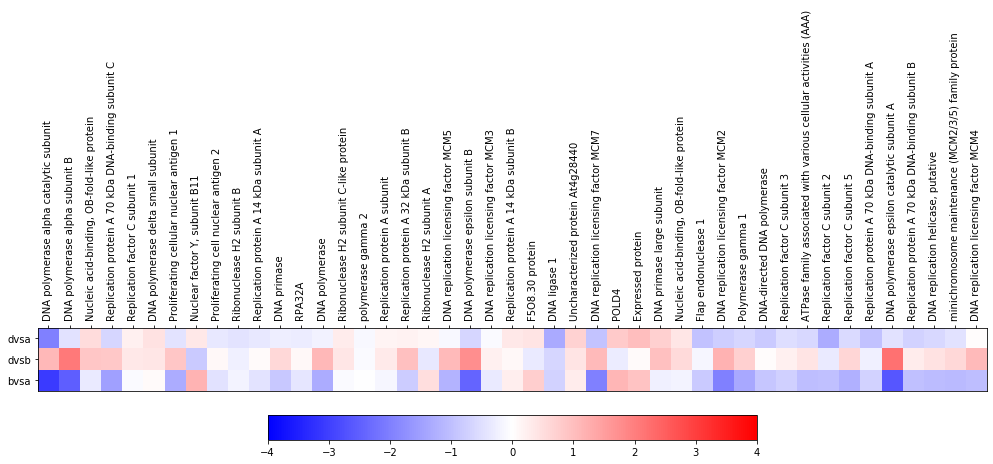

In [78]:
pathwaysToExplore = ['ath03030']
annotation = ['DNA replication']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description

Kegg gene ArthCp031 not found in RNA Seq data
Kegg gene AT1G43800 not found in RNA Seq data
Kegg gene AT4G11030 not found in RNA Seq data


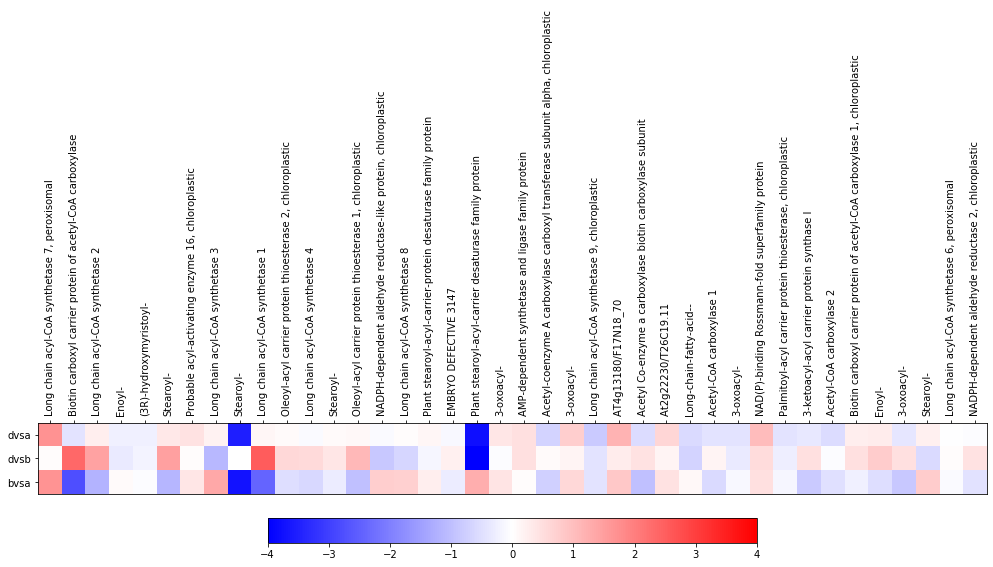

In [79]:
pathwaysToExplore = ['ath00061']
annotation = ['fatty acid biosynthesis']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description

Kegg gene AT4G37840 not found in RNA Seq data
Kegg gene AT3G25960 not found in RNA Seq data
Kegg gene AT3G55810 not found in RNA Seq data
Kegg gene AT4G26390 not found in RNA Seq data
Kegg gene AT1G22440 not found in RNA Seq data
Kegg gene AT4G22110 not found in RNA Seq data
Kegg gene AT5G15140 not found in RNA Seq data
Kegg gene AT3G01260 not found in RNA Seq data


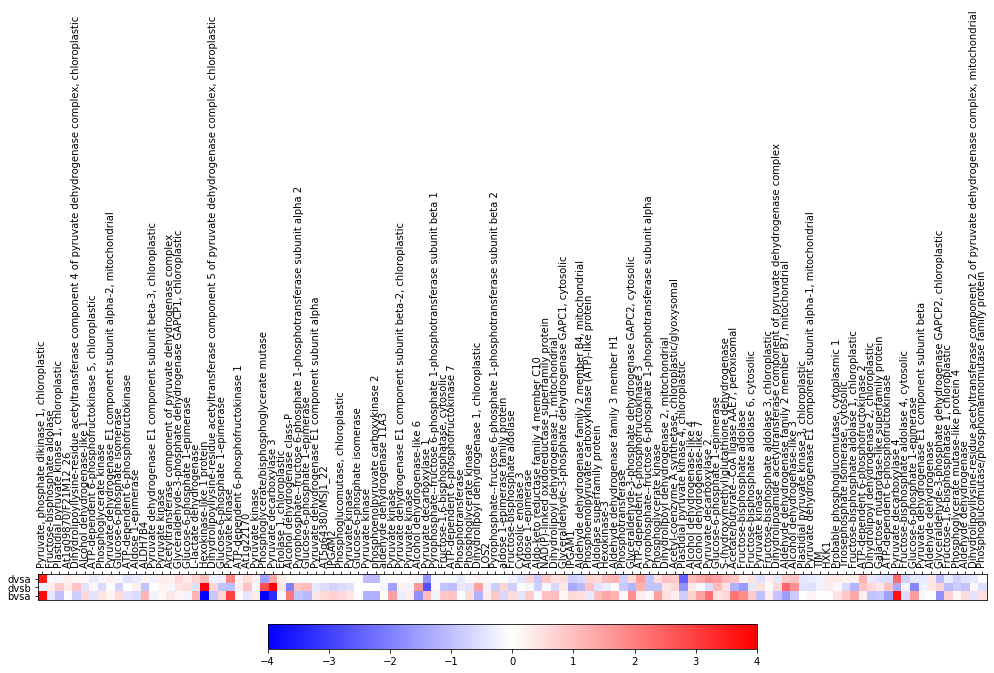

In [80]:
pathwaysToExplore = ['ath00010']
annotation = ['glycolysis']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
#book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
#with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
 #   writer.book = book
  #  writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
#    df3.to_excel(writer, name)  
#
 #   writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description

Kegg gene AT1G06310 not found in RNA Seq data
Kegg gene AT4G11030 not found in RNA Seq data
Kegg gene AT5G58860 not found in RNA Seq data
Kegg gene AT1G69500 not found in RNA Seq data
Kegg gene AT1G22440 not found in RNA Seq data
Kegg gene AT4G22110 not found in RNA Seq data


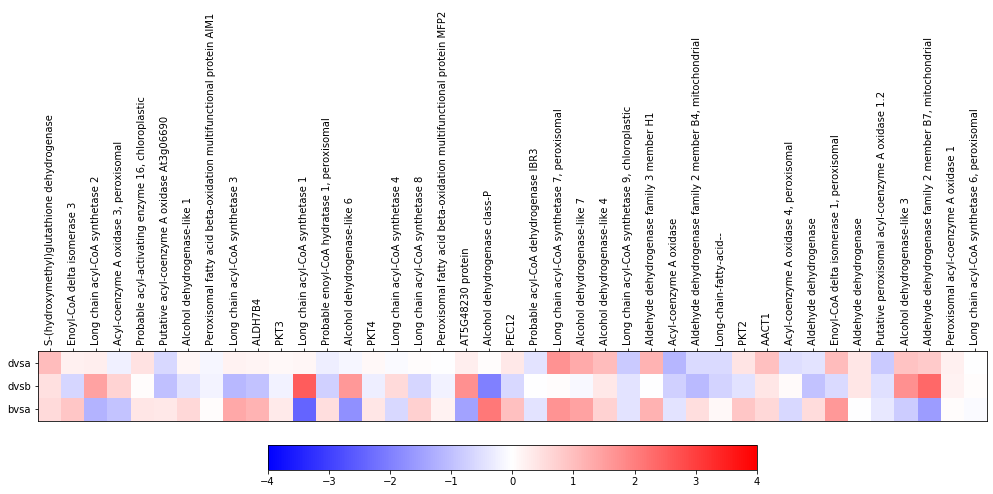

In [81]:
pathwaysToExplore = ['ath00071']
annotation = ['fatty acid degredation']
name = annotation[0]
#pathway to kegg name
pathwayDict = dict(zip(pathwaysToExplore,annotation))

dfx = parseKeggBiochemPathways(pathwaysToExplore,pathwayDict,DEG_data)
df2,df3,df = df_sorter(dfx)
book = load_workbook('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx')
with pd.ExcelWriter('C:/Users/Alyssa/Documents/RNA seq/python_export.xlsx', engine='openpyxl') as writer:
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

    ## Your dataframe to append. 
    df3.to_excel(writer, name)  

    writer.save()    
#colorPlotting(df2,df2.index) #plots with gene name
colorPlotting(df2,df) #plots with gene description